# What is Langgraph?

LangGraph is a powerful tool for building stateful, multi-actor applications with Large Language Models (LLMs). It extends the LangChain library, allowing you to coordinate multiple chains (or actors) across multiple steps of computation in a cyclic manner.

Key Features:
* State Management
* Flexible Routing
* Persistence
* Visualization

# Tutorial Overview: Building a Comprehensive Text Analysis Pipeline with LangGraph

In this tutorial, we'll harness the capabilities of LangGraph to design a multi-stage text analysis pipeline. Our practical example will guide you through processing input text via three pivotal phases:

Text Classification: Categorize input text into predefined categories, such as News, Blog, Research, or Other.

Entity Extraction: Identify and extract key entities, including persons, organizations, and locations, from the text.

Text Summarization: Generate a concise summary of the input text.

This pipeline demonstrates LangGraph's potential in creating modular, scalable workflows for natural language processing tasks. By completing this tutorial, you'll gain hands-on experience in constructing a graph-based application that can be easily tailored or expanded to meet diverse text analysis requirements.

# Install and Import Required Libraries

In [ ]:
!pip install langgraph langchain_openai langchain_core

In [6]:
!pip install python-dotenv

In [7]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image?

from dotenv import load_dotenv

In [ ]:
  !pip install python-dotenv colab

# Set Up API Key

In [11]:
import os
from google.colab import userdata


os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


openai_api_key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = openai_api_key


print("API Key loaded successfully!")

API Key loaded successfully!


# Building the Text Processing Pipeline

# Step 1: Defining the State Class and Initializing the LLM

In this section, we'll design the State class to encapsulate our workflow data and initialize the ChatOpenAI model, laying the foundation for our text processing pipeline.

In [12]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

#Define Node Functions

These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

In [13]:
def classification_node(state: State):
    ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    ''' Extract all the entities (Person, Organization, Location) from the text '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    ''' Summarize the text in one short sentence '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}




# Constructing the Workflow

In this step, we'll create the necessary tools and construct the StateGraph workflow, integrating the components to form a cohesive text processing pipeline.


In [14]:
workflow = StateGraph(State)


workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)


workflow.set_entry_point("classification_node") # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)


app = workflow.compile()

#Lets Visuaize the workflow

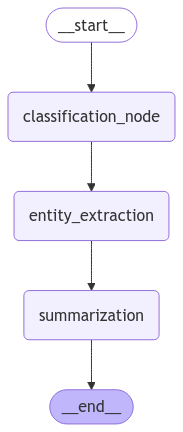

In [15]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [16]:
sample_text = """

During a live-streamed event, Musk introduced the advanced AI, showcasing its abilities in reasoning, in-depth research, and handling creative tasks. With Grok 3's unmatched performance in science, coding, and math, it has even outpaced industry giants like Google’s Gemini 2 Pro and OpenAI’s GPT-4.
The launch event highlighted the groundbreaking capabilities of Grok 3. Musk emphasised the model’s “maximally truth-seeking” nature, explaining that its goal is to provide deep, empathetic understanding even if it challenges politically correct views.
Subscription tiers and early access
xAI is rolling out Grok 3 to Premium+ subscribers on X, with users encouraged to update their app to access the new features. For those seeking earlier access and the most advanced capabilities, xAI has introduced a new subscription tier, Super Grok, available on both the Grok app and the newly launched website, grok.com.
Grok 3’s power and DeepSearch tool
Grok 3’s most significant upgrade lies in its computational power, boasting over 10 times the capacity of Grok 2. Built with a massive 2,00,000 GPU cluster housed in Memphis, Tennessee, the supercomputer, Colossus, was developed in under eight months. Musk revealed that Grok 3's pre-training completed in January, with daily improvements being rolled out, ensuring continuous development.

"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: News

Entities: ['Musk', 'Google', 'OpenAI', 'xAI', 'Memphis', 'Tennessee', 'Colossus']

Summary: Musk unveiled Grok 3, an advanced AI with superior capabilities in reasoning and creativity, surpassing competitors like Google and OpenAI, and introduced new subscription tiers for access.


So, we succesfully made a basic processing pipeline, using Langgraph